In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import copy
import torch

from utils.visualization import display_image_pair
from utils.dataset import read_config, load_dataset
from utils.correspondence import preprocess_image, preprocess_points, preprocess_bbox, compute_pck, postprocess_points

from models.luo import LuoModel
from models.hedlin import HedlinModel

In [30]:
model = 'luo'
dataset_config = 'dataset_config.json'
image_size = (224, 224)
device = 'cuda'
pck_threshold = 0.1

In [31]:
# Load model
if model == 'luo':
    model = LuoModel(1, image_size, device)
elif model == 'hedlin':
    model = HedlinModel()

device = torch.device(device)
#if device.type == 'cuda' and torch.cuda.device_count() > 1:
#    model = torch.nn.DataParallel(model)
#    print(f"Using {torch.cuda.device_count()} GPUs")
model.to(device)

# Load dataset config
dataset_config = read_config(dataset_config)

# Define preprocessor
def preprocess(sample):
    source_size = sample['source_image'].size
    target_size = sample['target_image'].size
    sample['source_image'] = preprocess_image(sample['source_image'], image_size)
    sample['target_image'] = preprocess_image(sample['target_image'], image_size)
    sample['source_points'] = preprocess_points(sample['source_points'], source_size, image_size)
    sample['target_points'] = preprocess_points(sample['target_points'], target_size, image_size)
    sample['source_bbox'] = preprocess_bbox(sample['source_bbox'], source_size, image_size)
    sample['target_bbox'] = preprocess_bbox(sample['target_bbox'], target_size, image_size)
    return sample

50


text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/export/home/ra63des/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


Evaluating dataset: SPair-71k


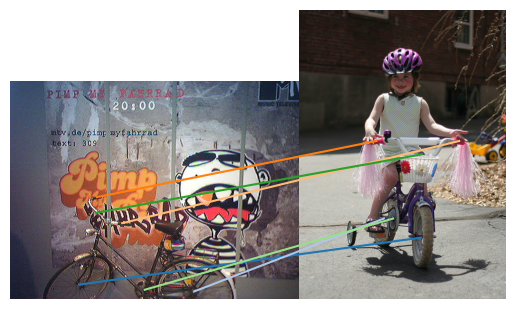

In [32]:
# Evaluate
config = dataset_config[0]
print(f"Evaluating dataset: {config['name']}")
dataset = load_dataset(config)

# Take first sample
unprocessed_sample = dataset[1]

# Visualize sample
display_image_pair(unprocessed_sample)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))
source_images = sample['source_image'].unsqueeze(0)
target_images = sample['target_image'].unsqueeze(0)
source_points = sample['source_points'].unsqueeze(0)
target_points = sample['target_points'].unsqueeze(0)
source_bbox = sample['source_bbox'].unsqueeze(0)
target_bbox = sample['target_bbox'].unsqueeze(0)

# load images on device
source_images, target_images = source_images.to(device), target_images.to(device)

In [33]:
# run through model
with torch.no_grad():
    predicted_points = model(source_images, target_images, source_points)

/export/home/ra63des/DistillDIFT/replicate/luo/archs/aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


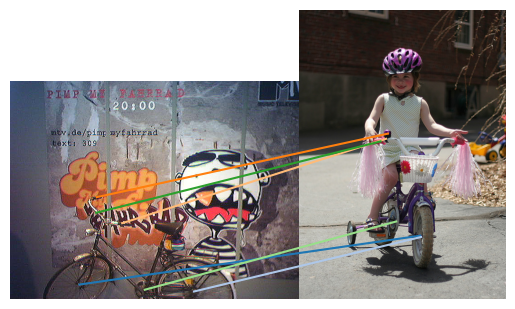

In [35]:
predicted_sample = copy.deepcopy(unprocessed_sample)
predicted_sample['target_points'] = postprocess_points(predicted_points[0], image_size, unprocessed_sample['target_image'].size).squeeze().cpu()
display_image_pair(predicted_sample)

In [34]:
# calculate PCK values
pck_img = 0
pck_bbox = 0
keypoints = 0
for i in range(len(source_points)):
    pck_img += compute_pck(predicted_points[i], target_points[i], image_size, pck_threshold)
    pck_bbox += compute_pck(predicted_points[i], target_points[i], image_size, pck_threshold, target_bbox[i])
    keypoints += len(source_points[i])

print(f"pck_img: {pck_img / keypoints}, pck_bbox: {pck_bbox / keypoints}")

pck_img: 0.5, pck_bbox: 0.3333333432674408
